In [43]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import numpy as np
from ModulationPy import ModulationPy
from commpy import rrcosfilter
from matplotlib import pyplot as plt
from IPython.display import Math, display, Markdown


from src.optics.split_step_fourier import SplitStepFourier
from src.general_methods.visualizer import Visualizer
from src.optics.myFNFTpy.FNFTpy import nsev_inverse_xi_wrapper, nsev_inverse, nsev

params
:
* $ W=50GHz \rightarrow 0.05 [THz] $
* $ L=1000km \rightarrow 1000 [km]$
* $ \beta_2=20*10^{-27} \rightarrow 20 [ps]$
* $ \eta=1.5 $

calculations
* $ T_G=\pi W |\beta_2|L = \pi \cdot 0.05 \cdot  20 \cdot 1000 = 1000\pi $
* $ N_s = \frac{WT_G}{\eta-1}=\frac{\pi W^2 |\beta_2|L}{\eta-1}=\frac{25\pi 10^{-4} |20|10^3}{1.5-1}= 100 \pi $

increasing that by 50% and rounding up we'll get:
* $ N_s = \lceil 100 \pi \cdot 1.5 \rceil \rightarrow N_s = 512 $ 

In [45]:
W_ghz = 50
L = 1000 # km
beta = 20 # ps^2/km
eta = 1.5 # spectral efficiency penalty factor (1,4]
W = W_ghz /1000 # GHz to THz

N_s_raw = W**2 * beta * L / (eta-1)
display(Markdown(f'raw: $\hat N_s = {N_s_raw:.0f} \pi $'))

# increase by 50% and round to nearest facotr of two:
N_s = int(2**np.ceil(np.log2(N_s_raw*np.pi*1.5)))
display(Markdown(f'$ \\rightarrow N_s = {N_s}$ symbols'))

raw: $\hat N_s = 100 \pi $

$ \rightarrow N_s = 512$ symbols

In [46]:
#burst size calculation
print("Burst size calculation")
T_b = eta * N_s / W
display(Markdown(
    f'$ T_b = \eta N_s / W  = {eta}*{N_s}/{W} = {T_b:.0f}ps = {T_b/1000:.1f}ns$'
    ))

Burst size calculation


$ T_b = \eta N_s / W  = 1.5*512/0.05 = 15360ps = 15.4ns$

### 0) input message:
we choose number of bits based on the number of symbols we want

so, number of bits: $ N_b = N_s*N_{sps} = 2048 $
where $ N_{sps} = log_2(M_{QAM}) = 4 $ is the num of samples per symbol

we get:
$ b=[b_0, b_1, ..., b_{N_b-1}] : b_i\in{0,1} \; \forall i$

In [47]:
m_qam = 16
num_symbols = 512
sps = int(np.log2(m_qam))
length_of_msg = num_symbols*sps
x0 = np.random.choice([0, 1], size=length_of_msg)

# plot
Visualizer.print_bits(x0, sps, 'message before channel')


_______________________________________________
message before channel - len=2048
[[1 1 0 1]
 [1 1 0 0]
 [1 1 0 0]
 ...
 [1 0 1 0]
 [0 0 0 0]
 [0 0 0 1]]


### 1) Modulation
$ c[\cdot] = f_{MOD}(b) = [c_0, c_1, ... , c_{N_s-1}] $

s.t:
* $ c_i = a_i + jb_i $
* $ f_{MOD}:B^{N_s*N_{sps}} \rightarrow C^{N_s}  $
* $ N_s = 512 $

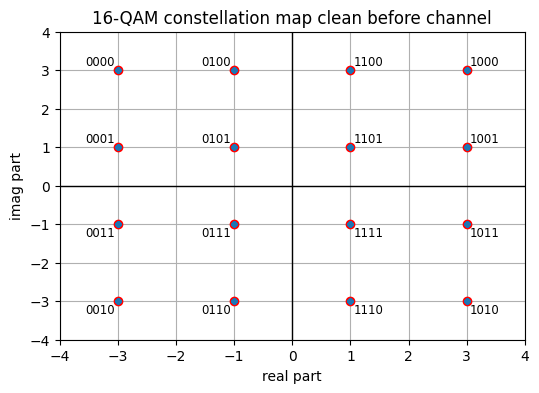

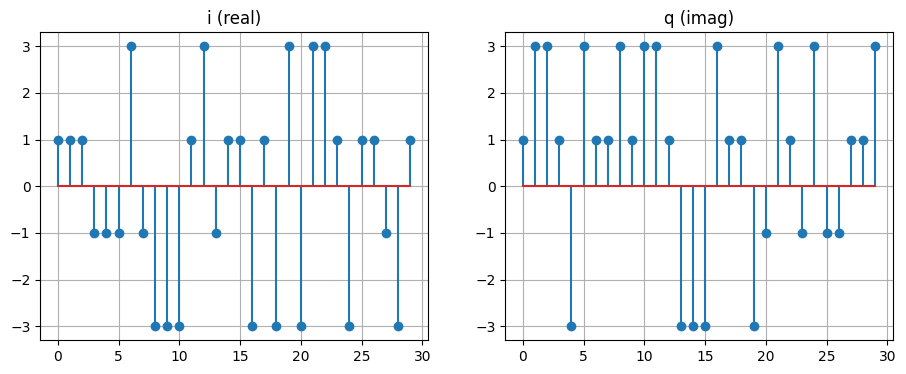

num of symbols = 512


In [48]:
modem = ModulationPy.QAMModem(m_qam, soft_decision=False)
x1 = modem.modulate(x0)

# plot
Visualizer.plot_constellation_map_with_points(x1, m_qam, 'clean before channel')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
Visualizer.my_plot(np.real(x1[0:30]), function='stem', name='i (real)', ax=ax1, hold=1)
Visualizer.my_plot(np.imag(x1[0:30]), function='stem', name='q (imag)', ax=ax2)
print(f'num of symbols = {len(x1)}')

### 2) over sampling

$ \hat c = [c_0, \underbrace{[0, 0, ..., 0]}_{N_{os}-1}, c_1, \underbrace{[0, 0, ..., 0]}_{N_{os}-1}, ..., c_{\hat N}, \underbrace{[0, 0, ..., 0]}_{N_{os}-1}] $

s.t:

$ \hat c \in R^{\hat N} : \hat N = N_s*N_{os}= 4096 $ <br>
$ N_{os} = 8 $

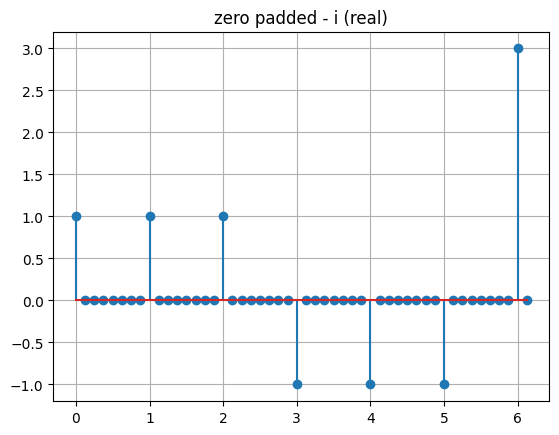

vec length = 4096, over_sampling period = 8


In [49]:
over_sampling = 8  # sampling rate

x2 = np.zeros(over_sampling*len(x1), dtype=np.complex64)
x2[::over_sampling] = x1

t_axis = np.arange(0, len(x2))/over_sampling

# plot
Visualizer.my_plot(t_axis[0:50], np.real(x2[0:50]), name='zero padded - i (real)', function='stem')
print(f'vec length = {len(x2)}, over_sampling period = {over_sampling}')

### 3) Pulse shaping
* $ \psi(t) \longrightarrow \psi_n=\psi(nT_s) \underset{Ts=1}{=}\psi(n) $
* $ u[\cdot] = c[\cdot] \circledast \psi[\cdot] $
  * $ u(\xi) = \sum_{n=-N_s/2}^{N_s/2-1} c_n \psi(\xi-n) $


where:
* length of h, $N_h$ is chosen such that the length of u, $N_u$ will be the next closest power of 2
  * (unless its too small [less than 100], so we skip to the next closest power of 2)

for $ \hat N = 4096 $ we chose $ N_h = 4097 $
and we get $ N_u = 8192 $

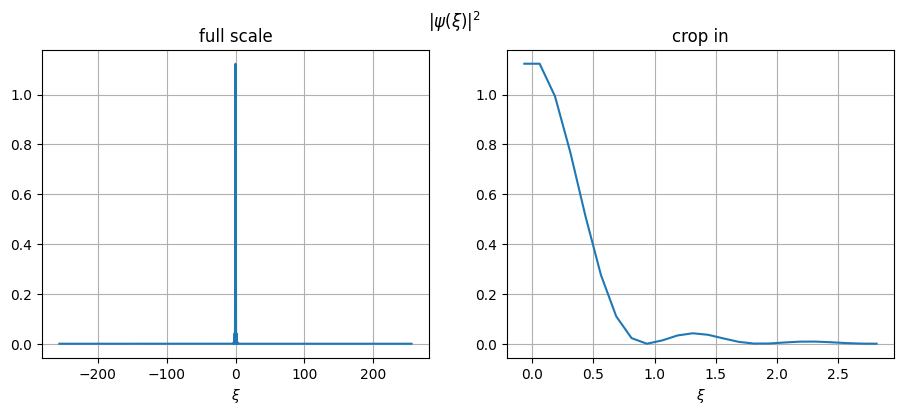

$$\begin{align*} u(\xi) = \sum_{n=-N_s/2}^{N_s/2-1} c_n \psi(\xi-n) \end{align*}$$

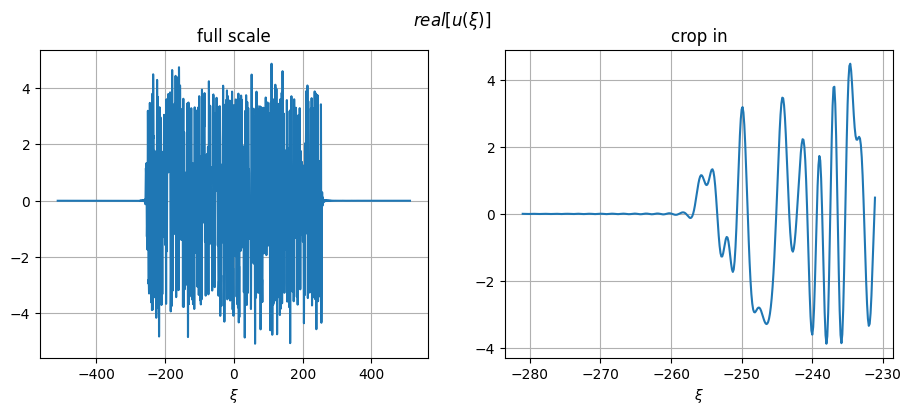

filter len = 4097, signal len = 8192


In [50]:
roll_off = 0.25  # filter roll-off factor
# Ts = 3000  # symbol period
Ts = 1  # symbol period

lenx = len(x2)
desired_len = int(2 ** np.ceil(np.log2(lenx)))  # the next power of 2
if desired_len - lenx < 100:
    desired_len = int(2 ** (1 + np.ceil(np.log2(lenx))))  # the next next power of 2

N_rrc = int(np.ceil(desired_len - lenx)) + 1
alpha: float = roll_off  # default = 0.25
fs = over_sampling/Ts
h_ind, h_rrc = rrcosfilter(N_rrc, alpha, Ts, fs)
x3 = np.convolve(h_rrc, x2)  # Waveform with PSF

# xi axis should be 1/ over sampling
xi_axis = np.arange(-len(x3)//2, len(x3)//2)/over_sampling

#plot
zm = range(N_rrc//2, N_rrc//2 + 24)
Visualizer.twin_zoom_plot(r'$|\psi(\xi)|^2$', np.abs(h_rrc) ** 2, zm, h_ind,xlabel=r'$\xi$')
display(Markdown(r"$$\begin{align*} u(\xi) = \sum_{n=-N_s/2}^{N_s/2-1} c_n \psi(\xi-n) \end{align*}$$"))
Visualizer.twin_zoom_plot(r'$real[ u(\xi) ]$', np.real(x3), range(N_rrc//2-200, N_rrc//2+200),
                          xi_axis, xlabel=r'$\xi$')

print(f'filter len = {N_rrc}, signal len = {len(x3)}')

### 4) pre-equalize
 - normalize by $\mu$:   $ \hat u(\xi) = \mu \cdot u(\xi)$
 - scaling amplitude to [0,1]:
    - $ b(\xi) = \sqrt{1 - e^{-|\hat u (\xi)|^2}} \cdot e^{j\angle \hat u (\xi)} $


$$\begin{align*} u(\xi) = \sum_{n=-N_s/2}^{N_s/2-1} c_n \psi(\xi-n)\qquad \qquad \qquad \hat u(\xi) = \mu \cdot u(\xi)\qquad \qquad \qquad b(\xi) = \sqrt{1 - e^{-|\hat u (\xi)|^2}} \cdot e^{j\angle \hat u (\xi)} \end{align*}$$

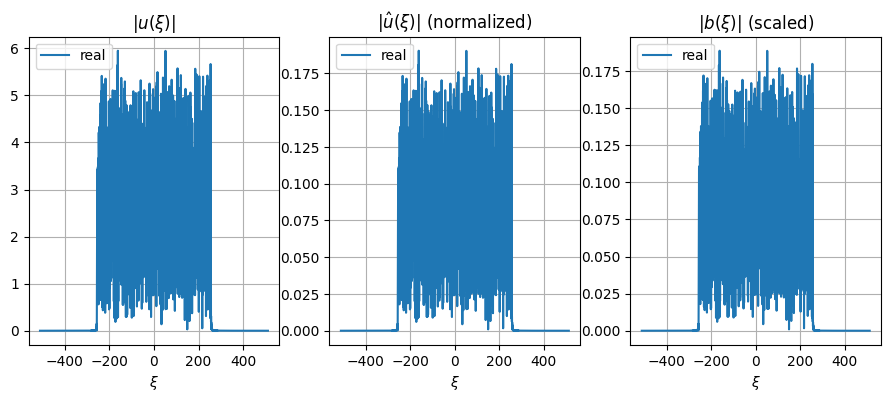

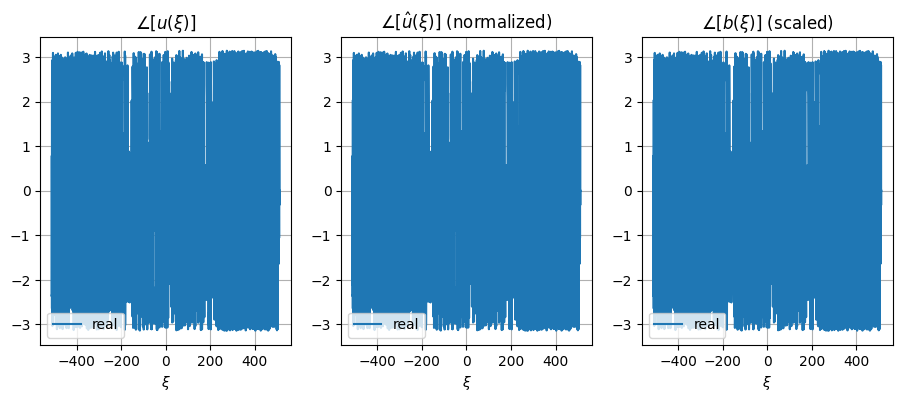

In [51]:
# normalization_factor: float = 0.32
normalization_factor: float = 0.032
# normalization_factor: float = 1e3
x41 = normalization_factor*x3

# #scaling
    #get amp_phase
amp = np.abs(x41)
phase = np.angle(x41)

    # sigmoid
# scaled_amp = 2 / (1 + np.exp(-amp)) - 1 # old scaling - sigmoid
scaled_amp = np.sqrt(1 - np.exp(-amp**2)) # new scaling - by stas' doc

    # get complex from amp_phase
x4 = scaled_amp * np.exp(1j * phase)

assert np.all(0 <= np.abs(x4)) and np.all(np.abs(x4) <= 1), 'scaled signal is not in the range [0,1]'

# # plot - abs of all
eq = r'u(\xi) = \sum_{n=-N_s/2}^{N_s/2-1} c_n \psi(\xi-n)'
eq += r'\qquad \qquad \qquad \hat u(\xi) = \mu \cdot u(\xi)'
eq += r'\qquad \qquad \qquad b(\xi) = \sqrt{1 - e^{-|\hat u (\xi)|^2}} \cdot e^{j\angle \hat u (\xi)}'
Visualizer.print_equation(eq)

Visualizer.data_trio_plot(
    np.abs(x3), np.abs(x41), np.abs(x4),
    None, None,xi_axis, r'$\xi$',
    names=[r'$|u(\xi)|$',r'$|\hatu(\xi)|$ (normalized)',r'$|b(\xi)|$ (scaled)'],
)
# plot - real of all
Visualizer.data_trio_plot(
    np.angle(x3), np.angle(x41), np.angle(x4),
    None, None,xi_axis, r'$\xi$',
    names=[r'$\angle[u(\xi)]$',r'$\angle[\hatu(\xi)]$ (normalized)',r'$\angle[b(\xi)]$ (scaled)'],
)

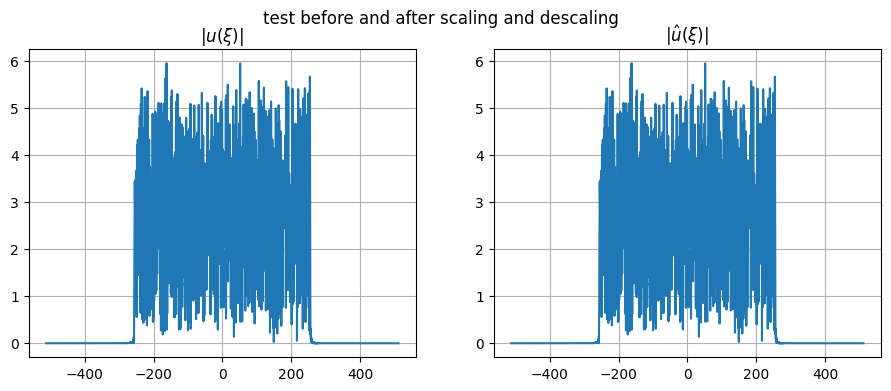

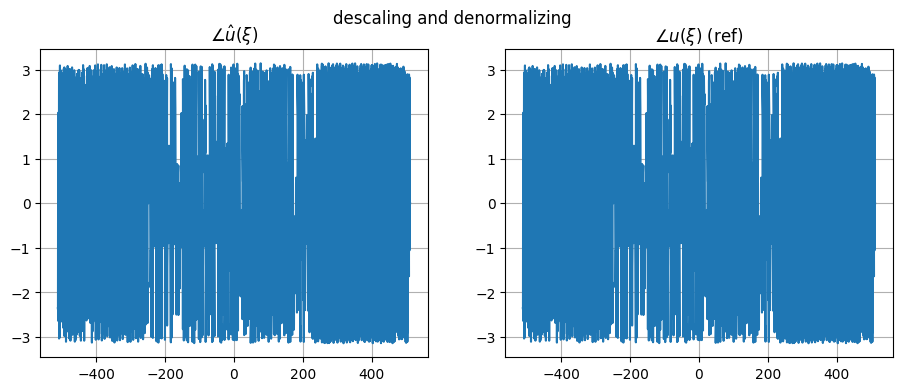

In [52]:
# test - reverse scaling 
#descale
    #get amp_phase
amp = np.abs(x4)
phase = np.angle(x4)
    # desigmoid
# descaled_amp = -np.log((2 / (amp + 1)) - 1) # old descaling - sigmoid
descaled_amp = np.sqrt(-np.log(1 - amp**2)) # new descaling - by stas' doc
    # get complex from amp_phase
x71_test = descaled_amp * np.exp(1j * phase)

# normalize
x8_test = x71_test / normalization_factor

# plot

Visualizer.double_plot(
    'test before and after scaling and descaling',
    np.abs(x3), np.abs(x8_test),
    xi_axis,xi_axis,
    r'$|u(\xi)|$',r'$|\hat{u}(\xi)|$'
)

Visualizer.double_plot(
    'descaling and denormalizing',
    np.angle(x8_test), np.angle(x3),
    xi_axis,xi_axis,
    r'$\angle \hat u(\xi)$',r'$\angle u(\xi)$ (ref)'
)

# TODO: half propagation step

$ b(0,\xi) = b(\xi)e^{-j\xi^2 l} $

In [53]:
# TODO: half propogation step
x4 = x4 * np.exp(-1j * xi_axis**2 * (L))


### 5) INFT

$ q(t) = \mathcal{F}^{-1}\{b(\xi)\} $

with the following params:
* $ N_\xi = N_{s} \cdot N_{os} = len(b(\xi)) $
* $ N_{t} = 2 ^ {\lceil log_2(N_\xi) \rceil}$
* $ \sout{T_{NFT} = \pi N_{os} N_s / W }$
* $ T_{NFT} = \pi N_{os} $
* $ t = [\frac{-T_{NFT}}{2}:\frac{T_{NFT}}{2}] $

In [54]:
# generate INFT params:
N_xi = len(x4)
N_time = int(2 ** np.ceil(np.log2(N_xi)))  # (=D) - rounding to the nearest power of 2
# T_NFT=np.pi*over_sampling*N_s/W
T_NFT=np.pi*over_sampling
# tvec = np.arange(start=-N_time/2, stop=N_time/2)*1  # old way that worked
tvec = np.linspace(-T_NFT/2, T_NFT/2, N_time)
dt = tvec[1] - tvec[0] # -> should be in pico seconds
# rv, xi = nsev_inverse_xi_wrapper(N_time, tvec[0], tvec[-1], N_xi, display_c_msg=True)
# xivec = xi[0] + np.arange(N_xi)*(xi[1] - xi[0])/(N_xi - 1)
xivec = xi_axis
dxi= xivec[1] - xivec[0] # should be equal to 1/over_sampling (verify if debug)
BW = xivec.max()

nyquist_t = np.pi/BW


#plot
print(f'axes specs:')
display(Math(
    rf'\xi \in [{xivec[0]/1:.2f}:{xivec[-1]/1:.2f}] \text{{ Hz }} \qquad N_\xi   = M = {N_xi} \qquad  \Delta \xi = {dxi/1:.3f} \text{{ Hz }}\\'
    rf't  \in [{tvec[0]*1:.3f}:{tvec[-1]*1:.3f}] \text{{ s }} \qquad \quad N_{{t}} = D = {N_time} \qquad \Delta t = {dt/1:.5f} \text{{ s}}'
))
print(f'where:')
display(Math(
    rf'\text{{Nyquist time threshold:}} \frac{{\pi}}{{BW}} = {nyquist_t/1:.5f} \text{{ s}} \\'
    rf'BW = {BW/1:.2f} \text{{ Hz }}'
))

# Visualizer.twin_zoom_plot('real{X(xi)}', np.real(x4), range(4000, 4200), xivec, xlabel='xi')


axes specs:


<IPython.core.display.Math object>

where:


<IPython.core.display.Math object>

length of INFT(x) = 8192
signal power = 2.35e+01
signal bw = [-1.26e+01:1.26e+01]


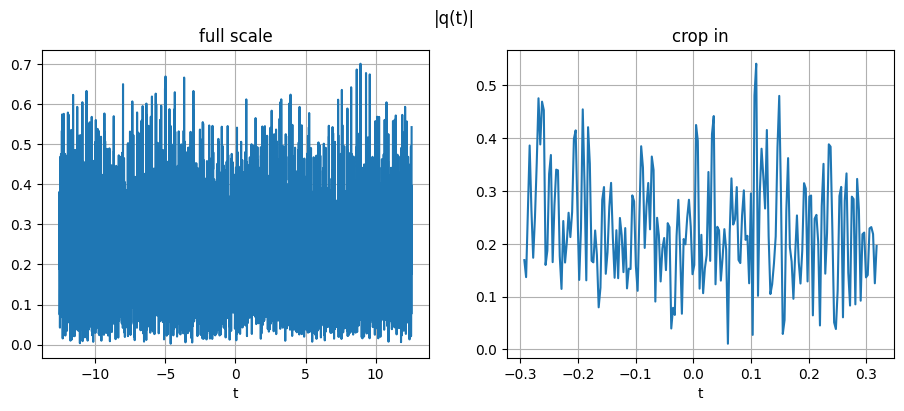

In [55]:
# INFT
contspec = x4
bound_states = []  # np.array([0.7j, 1.7j])
discspec = []  # [1.0, -1.0]

cst = 1  # continuous spectrum type - default is None
dst = 0  # default is None

res = nsev_inverse(xivec, tvec, contspec, bound_states, discspec,
                   cst=cst, dst=dst, display_c_msg=True)

assert res['return_value'] == 0, "INFT failed"
x5 = res['q']  # q[t,0]

# plot
print(f'length of INFT(x) = {len(x5)}')
Visualizer.print_signal_specs(x5, tvec)
Visualizer.twin_zoom_plot('|q(t)|', np.abs(x5), range(4000, 4200), tvec, 't')

### 6) SSF

now we go through the SSF channel
which has N iterations

#### algorithm:
* $a\in \mathbb{C}^{N_t}$
* $a = a \cdot \sqrt{P_0}$
* $w = [0,...,\frac{N_t}{2}-1,\frac{-N_t}{2},...,-1] \cdot \frac{2 \pi}{N_t \cdot dt}$
* $ v_1 = \exp\left(\frac{j \cdot \beta_2}{2} \cdot w^2 \cdot \frac{\Delta_z}{2}\right) $
* $a = \mathcal{F}(a)$
* Loop $N=\frac{Z_N}{\Delta_z}$ times:
    * $a = \mathcal{F}^{-1}(a \cdot v_1)$
    * $n\in\mathbb{C}^{N_t} \sim N(0,1)$
    * $a = a + \sqrt{\frac{D\cdot \Delta_z}{dt}}\cdot n$
    * $a = a \cdot \exp\left(j \cdot \gamma \cdot \Delta_z \cdot |a|^2\right)$
    * $a = v_1 \cdot \mathcal{F}(a)$
* $a = \mathcal{F}^{-1}(a)$
* $a = a \cdot \frac{1}{\sqrt{P_0}}$


In [56]:
# ssf = SplitStepFourier(
#     b2=-20e-27, # units of SI (s^2/m)
#     gamma=0.003,
#     t0=125e-12,
#     dt=1, 
#     z_n=1000e3, 
#     dz=200, ####
#     with_noise=True,
#     verbose=True
# )

# x6 = ssf(x5)
x6 = x5

# Visualizer.twin_zoom_plot('real X(xi)', np.real(x6), range(4000, 4200))

### 7) NFT
nft back to $ \xi $ domain

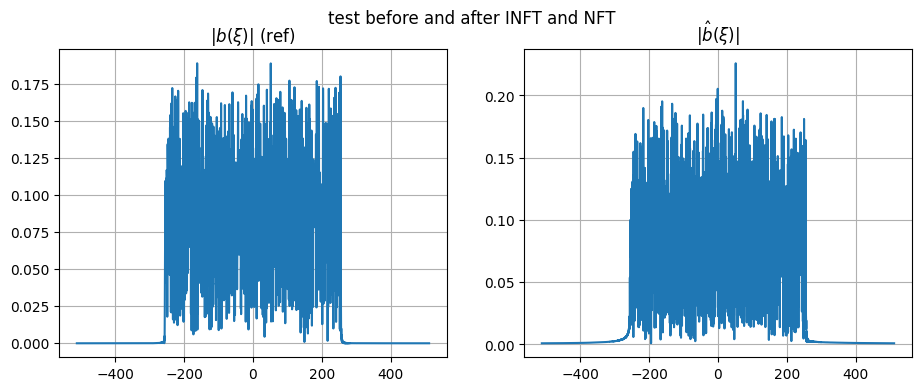

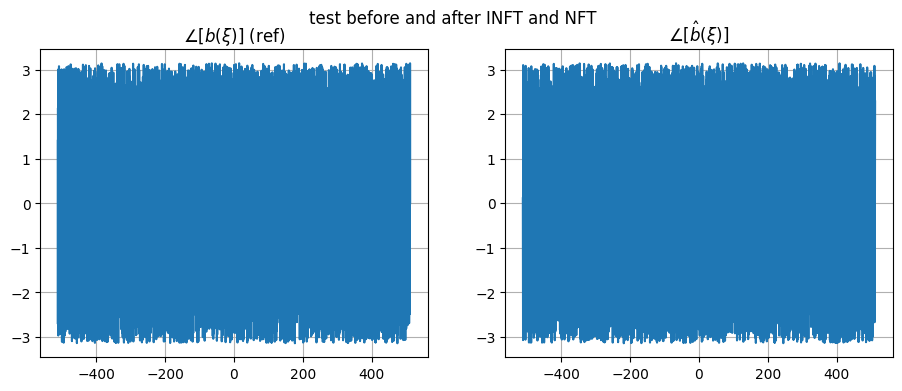

In [57]:
res = nsev(x6, tvec, Xi1=-BW, Xi2=BW, M=N_xi, display_c_msg=True, cst = cst)
assert res['return_value'] == 0, "NFT failed"
x7 = res['cont_b']

x7 = x7 * np.exp(-1j * xivec**2 * (L))


# plot
Visualizer.double_plot(
    'test before and after INFT and NFT',
    np.abs(x4), np.abs(x7),
    xivec,xivec,
    r'$|b(\xi)|$ (ref)',r'$|\hat{b}(\xi)|$'
)

Visualizer.double_plot(
    'test before and after INFT and NFT',
    np.angle(x4), np.angle(x7),
    xivec,xivec,
    r'$\angle[b(\xi)]$ (ref)',r'$\angle[\hat{b}(\xi)]$'
)


/tmp/ipykernel_2238684/3953592799.py:4: RuntimeWarning: divide by zero encountered in divide
  ratio = b_out / b_in


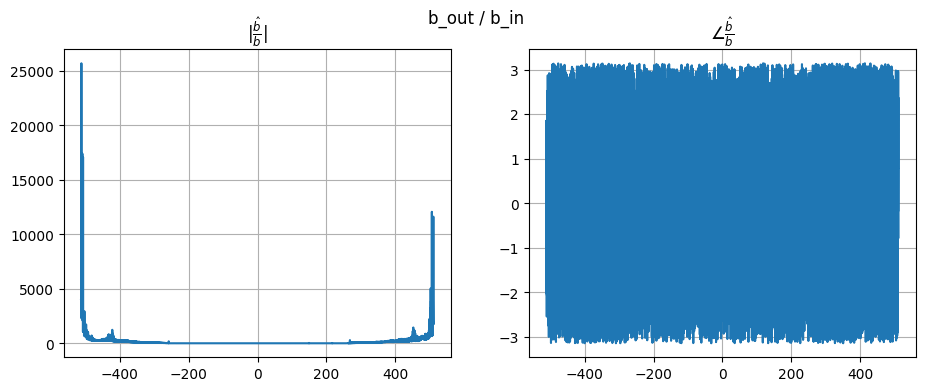

In [58]:
b_out = x7
b_in = x4

ratio = b_out / b_in

# plot
Visualizer.double_plot(
    'b_out / b_in',
    np.abs(ratio), np.angle(ratio),
    xivec,xivec,
    r'$|\frac{\hat{b}}{b}|$',r'$\angle \frac{\hat{b}}{b} $'
)

### TODO: half propagation step
$ \hat b(\xi) = b(l,\xi)e^{-j\xi^2l} $

In [59]:
# TODO: half propogation step 
    # b_out = b_out * np.exp(-1j * xi**2 * (L/Zn))


### 8) Equalizer
descale:
$ y = \sqrt{-ln(1-b)} \cdot e^{\angle{b}} $

normalize back
$ \hat X(\xi) = X / \mu$

and later on the deep learning model should be placed here


<IPython.core.display.Math object>

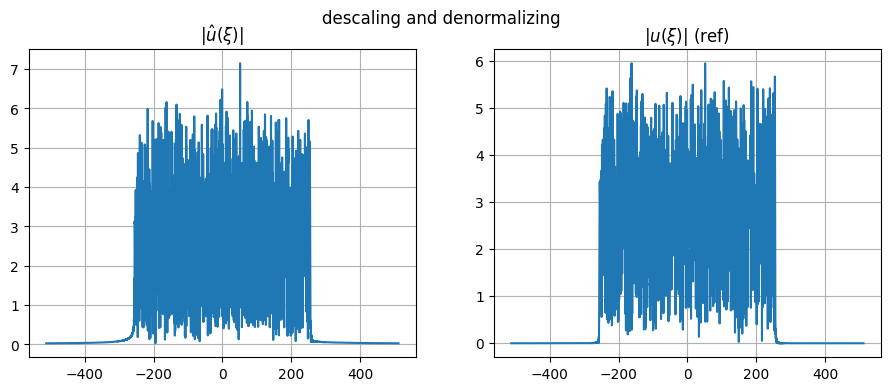

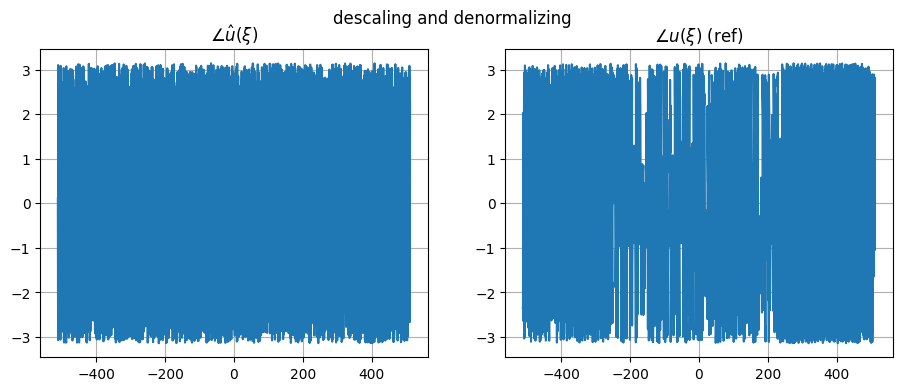

In [60]:
# #descale
#     #get amp_phase
# amp = np.abs(x7)
# phase = np.angle(x7)
#     # desigmoid
# # descaled_amp = -np.log((2 / (amp + 1)) - 1) # old descaling - sigmoid
# descaled_amp = np.sqrt(-np.log(1 - amp**2)) # new descaling - by stas' doc
#     # get complex from amp_phase
# x71 = descaled_amp * np.exp(1j * phase)

# # normalize
# x8 = x71 / normalization_factor

########
# test - reverse scaling 
#descale
    #get amp_phase
amp = np.abs(x7)
phase = np.angle(x7)
    # desigmoid
# descaled_amp = -np.log((2 / (amp + 1)) - 1) # old descaling - sigmoid
descaled_amp = np.sqrt(-np.log(1 - amp**2)) # new descaling - by stas' doc
    # get complex from amp_phase
x71_test = descaled_amp * np.exp(1j * phase)

# normalize
x8 = x71_test / normalization_factor
#########


display(Math(r'\text{normalization factor: } \mu = ' + f'{normalization_factor}'))

# plot
Visualizer.double_plot(
    'descaling and denormalizing',
    np.abs(x8), np.abs(x3),
    xivec,xivec,
    r'$|\hat u(\xi)|$',r'$|u(\xi)|$ (ref)'
)

Visualizer.double_plot(
    'descaling and denormalizing',
    np.angle(x8), np.angle(x3),
    xivec,xivec,
    r'$\angle \hat u(\xi)$',r'$\angle u(\xi)$ (ref)'
)

### 9) Match Filter
convolve again with the rrc filter and sample every $ N_{over sample}=8 $ points, those points are free from inter symbol interference (aliasing)

* $ \hat{\tilde{c}} = \tilde{u} \circledast \psi $
* $ \hat{c}[n] = \hat{\tilde{c}}[nN_{os}] / N_{os} $

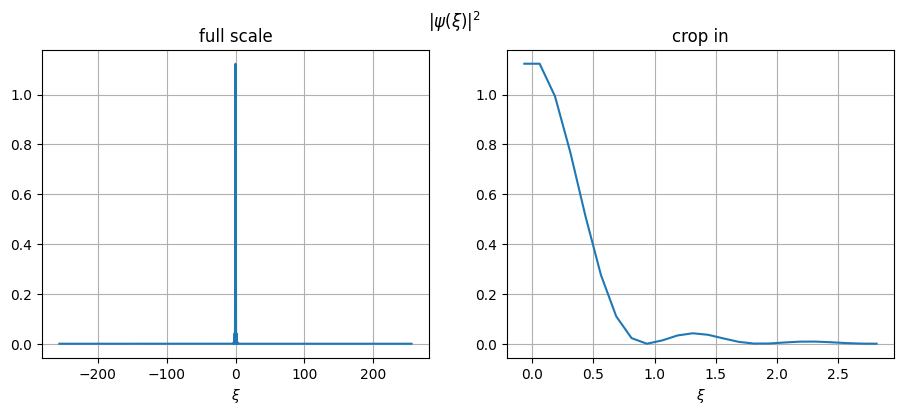

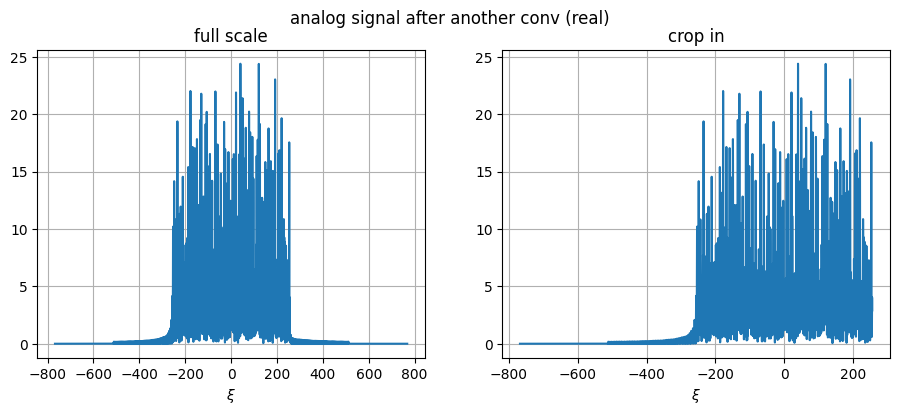

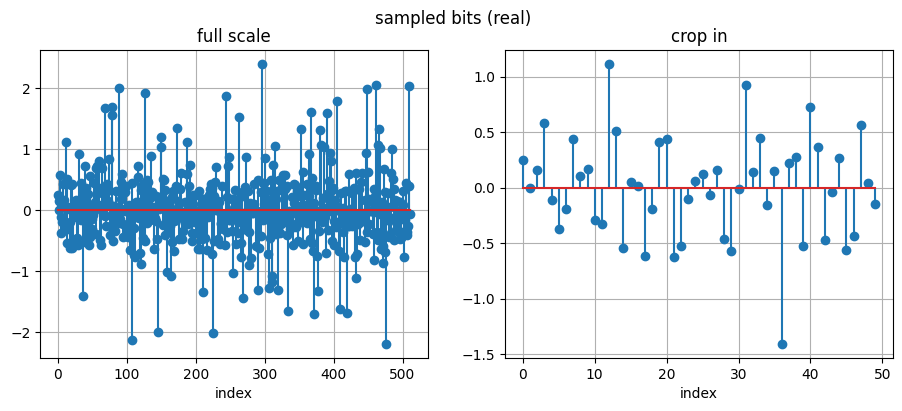

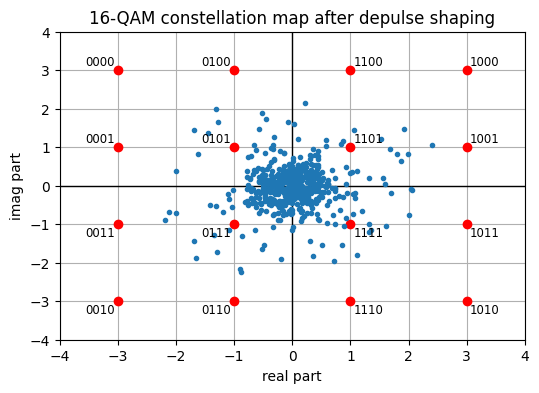

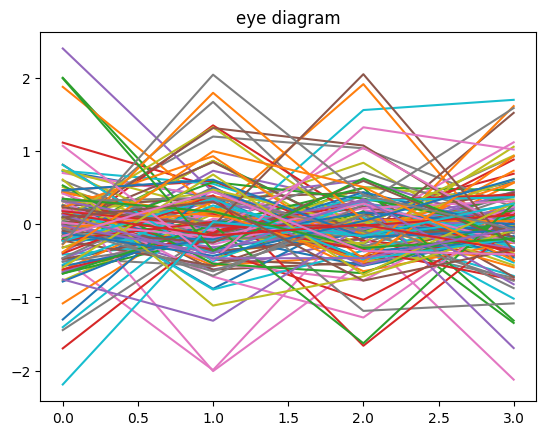

num of sampled symbols = 512 


In [61]:
y1 = np.convolve(x8, h_rrc)
xivec2 = np.arange(-len(y1)//2, len(y1)//2)/over_sampling


# sampling the analog vector into discrete bits
start = N_rrc
stop = - N_rrc  # + over_sampling
step = over_sampling
x9 = y1[start:stop:step] / over_sampling


Visualizer.twin_zoom_plot(r'$|\psi(\xi)|^2$', np.abs(h_rrc) ** 2, range(N_rrc//2, N_rrc//2 + 24), h_ind,xlabel=r'$\xi$')
Visualizer.twin_zoom_plot('analog signal after another conv (real)',np.abs(y1),range(0,2*N_rrc),xivec2,r'$\xi$')
# Visualizer.twin_zoom_plot('analog signal after another conv (real)',np.abs(y1),range(0,2*N_rrc))
Visualizer.twin_zoom_plot('sampled bits (real)',np.real(x9),range(0,50),function='stem')
Visualizer.plot_constellation_map_with_points(x9, m_qam, 'after depulse shaping')
Visualizer.eye_diagram(x9, sps=sps)
print(f'num of sampled symbols = {len(x9)} ')

### 10) demodulation
restore back from i q symbols to bits

In [62]:
x10 = modem.demodulate(x9)

#plot
Visualizer.print_bits(x10, sps, 'message after channel')


_______________________________________________
message after channel - len=2048
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 1.]
 ...
 [1. 0. 1. 1.]
 [1. 1. 1. 1.]
 [0. 1. 0. 1.]]


### Evaluate:
calculate ber

In [63]:
num_errors = (x0 != x10).sum()
ber = num_errors / length_of_msg

print(f'ber = {ber} = {num_errors}/{length_of_msg}')


ber = 0.50927734375 = 1043/2048
